# Setup
Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

# Agent

The plant in which inhabits a given ecosystem.

### Attributes:
- **loc**: (x,y) location on grid of object
- **age**: number of steps plant has been alive, incremented each step
- **size**: 'vertical height' of plant (used to determine survival when fighting for resources)
- **type**: species of plant
- **lifespan**: Age at which the plant will die
- **resilience**: Constant used to determine survival when fighting for limited resources
- **growth_rate**: The amount in which size will be increased by every step
- **reproduction_area**: The area around the plant in which new plants can be created
- **reproduction_rate**: For any of the given surrounding neighbours, in an area defined by the reproduction_area, if unoccupied, the chance that a new plant of the same type will appear

In [2]:
class Plant:

    def __init__(self, location, params):
        
        self.genes = params
        self.loc = tuple(location)
        self.age = 0
        self.size = 0
        self.type = params["type"]
        self.colour = params["colour"]
        self.lifespan = int(np.random.uniform(params["min_lifespan"], params["max_lifespan"]))
        self.resilience = np.random.uniform(params["min_resilience"], params["max_resilience"])
        self.growth_rate = np.random.uniform(params["min_growth_rate"], params["max_growth_rate"])
        self.reproduction_rate = np.random.uniform(params["min_reproduction_rate"], params["max_reproduction_rate"])
        self.reproduction_area = params["reproduction_area"]

    def step(self):
        self.age += 1
        self.size = self.size + self.growth_rate
        return 0
    
    def reproduce(self, ecosystem):
        # return a list of plants of the same type to be input into the eco
        empty_neighbours = ecosystem.get_empty_neighbours(self)
        if(len(empty_neighbours) == 0):
            return []
        offspring = []
        for empty_neighbour in empty_neighbours:
            random_zero_to_one = np.random.random()
            if random_zero_to_one < self.reproduction_rate:
                # generate a new agent
                temp_plant = Plant(empty_neighbour, self.genes)
                offspring.append(temp_plant)
        return offspring
    
    def is_old(self):
        return self.age >= self.lifespan
    


# Environment

The environment in which the plants will be housed.

### Attributes:
- **n**: Number of rows and columns for the grid.
- **params**: Dictionary of parameters.
- **agents**: List of plant agents in the environment.
- **occupied**: List of locations occupied by plants.
- **competition_constant** : Constant used to determine competition between plants.
- **flora_types**: List of different types of flora in the environment.
- **colours**: List of colours representing different flora types.
- **array**: 2D grid representing the environment, initialized with zeros.
- **just_died**: List to track locations where plants have just died to prevent immediate replacement.

In [3]:
from Cell2D import Cell2D
from matplotlib.colors import ListedColormap, BoundaryNorm

class Ecosystem(Cell2D):
    """Represents a given ecoystem."""

    def __init__(self, n: int, params: dict):
        """Initializes the attributes.
        n: number of rows and columns
        params: dictionary of parameters
        """

        self.n = n
        self.params = params
        self.agents = list(params.get("plants"))
        self.occupied = [agent.loc for agent in self.agents]
        self.competition_constant = params.get("competition_constant")
        self.flora_types = params.get("flora_types")
        self.colours = params.get("colours")
        self.array = np.zeros((n,n))
        self.just_died = [] #Use this list to ensure entities are not replaced in squares where they just died, and each round is an actual round

    def make_agents(self, agents: dict[Plant, str]):
        """
        Populate the ecoystem with flora.
        This function takes given, specified
        plants populates the ecosystem with them. 
        """
        for current_agent in agents:
            self.add_plant(current_agent)

    def add_plant(self, agent: Plant):
        """Add a given plant to the ecosystem"""
        if not agent.loc in self.just_died:
            self.agents.append(agent)
            self.occupied.append(agent.loc)
    
    def remove_plant(self, agent: Plant):
        """ Remove a plant from the ecosystem"""
        self.agents.remove(agent)
        self.occupied.remove(agent.loc)
        self.just_died.append(agent.loc)

    def get_neighbours(self, agent: Plant, radii: int):
        loc_row = agent.loc[0]
        loc_column = agent.loc[1]

        row_start = max(0, loc_row-radii)
        row_end = min(self.array.shape[0], loc_row+(radii+1))
        
        col_start = max(0, loc_column-radii)
        col_end = min(self.array.shape[1], loc_column+(radii+1))

        neighbours = []
        for row in range(row_start, row_end):
            for col in range(col_start, col_end):
                # Exclude the current plant itself
                if not (row == loc_row and col == loc_column):
                    neighbours.append((row,col))
         
        return neighbours

    def get_empty_neighbours(self, agent: Plant):
        # Define the range for rows and columns, ensuring the indices don't go out of bounds

        neighbours = self.get_neighbours(agent, agent.reproduction_area)
        empty_neighbours = []

        for neighbour in neighbours:
            if not (neighbour in self.occupied):
                empty_neighbours.append(neighbour)

        return empty_neighbours
    
    def get_occupied_neighbours_agents(self, agent: Plant):
        neighbours = self.get_neighbours(agent,1)
        occupied_neighbours = []

        for neighbour in neighbours:
            if (neighbour in self.occupied):
                for each_agent in self.agents:
                    if each_agent.loc == neighbour:
                        occupied_neighbours.append(each_agent)
        return occupied_neighbours
    
    def check_competition(self, agent: Plant):
        occupied_neighbours = self.get_occupied_neighbours_agents(agent)
        if not occupied_neighbours is None:
            for neighbour in occupied_neighbours:
                random_zero_to_one = np.random.random()
                if random_zero_to_one < self.competition_constant:
                    if agent.size + agent.resilience > neighbour.size + neighbour.resilience:
                        self.remove_plant(neighbour)
                    else:
                        self.remove_plant(agent)
                        return
        

    def step(self):
        """Executes one time step."""

        self.just_died = [] #Reset this each step


        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            if agent in self.agents: #might have been removed midway
                agent.step()

                # If the agent plant is too old, remove from the ecosystem
                if agent.is_old():
                    #self.array[agent.loc] = 3 #Death colour (TEMP) (should be red)
                    self.remove_plant(agent)
                    

                else:
                    # Generate plant(s) next to the current one
                    self.check_competition(agent)

                    offspring = agent.reproduce(self)
                    if len(offspring) != 0:
                        for new_plant in offspring:
                            self.add_plant(new_plant)

                    

        return len(self.agents)

    def draw(self):
        """Draws the ecosystem as a cellular automata grid."""
        # Clear the previous figure
        plt.clf()
        
        cmap = ListedColormap(self.colours)
        bound = []
        for i in range(len(self.flora_types) + 2):
            bound.append(i)
        norm = BoundaryNorm(bound, cmap.N)
        # Update the array based on the positions of the agents
        for agent in self.agents:
            for index, type in enumerate(self.flora_types):
                if agent.type == type:
                        self.array[agent.loc] = index + 1


        # Draw the ecosystem grid
        plt.imshow(self.array, cmap=cmap, norm=norm, origin='lower')
        plt.gca().axes.get_xaxis().set_visible(False)  # Hide x-axis
        plt.gca().axes.get_yaxis().set_visible(False)   
        plt.title('Ecosystem Cellular Automata Visualization')
        plt.show()

        # Reset the array to zero for the next step
        self.array.fill(0)

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        rows, cols = np.transpose([agent.loc for agent in self.agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

## Tree vs Weed:

The premise behind this test is to display the effects of reproduction rate and resilience.

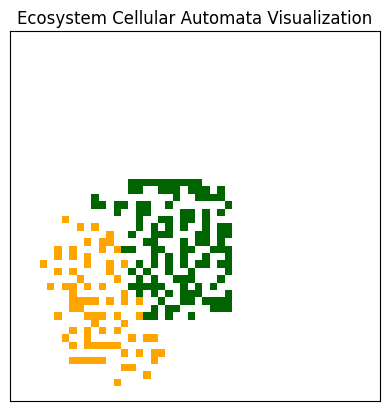

In [19]:
# Example parameters for the plant
plant_1_params = {
    "type": "Tree",
    "colour": "orange",
    "min_lifespan": 10,
    "max_lifespan": 20,
    "min_resilience": 0.85,
    "max_resilience": 1.0,
    "min_growth_rate": 0.1,
    "max_growth_rate": 0.3,
    "min_reproduction_rate": 0.05,
    "max_reproduction_rate": 0.1,
    "reproduction_area": 2}

plant_2_params = {
    "type": "Weed",
    "colour": "darkgreen",
    "min_lifespan": 2,
    "max_lifespan": 3,
    "min_resilience": 0.1,
    "max_resilience": 0.3,
    "min_growth_rate": 0.3,
    "max_growth_rate": 0.8,
    "min_reproduction_rate": 0.7,
    "max_reproduction_rate": 0.9,
    "reproduction_area": 1
}

# Create plant instances
plants = []
plants.append(Plant((15, 10), plant_1_params))
plants.append(Plant((20, 20), plant_2_params))

flora_types = [plant.type for plant in plants]
colours = ["white"] + [plant.colour for plant in plants]

params = {
    "plants": plants,
    "competition_constant": 0.5, 
    "flora_types": flora_types,
    "colours": colours
    }
# Example output to show its properties
desert = Ecosystem(50, params)

desert.animate(10, interval=1)

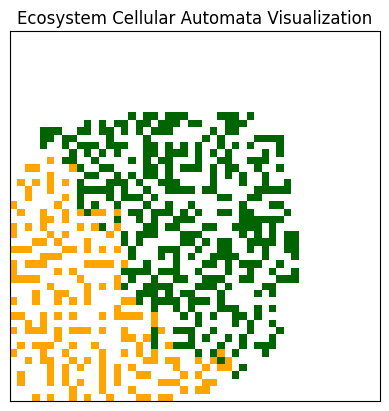

In [20]:
desert.animate(10, interval=1)

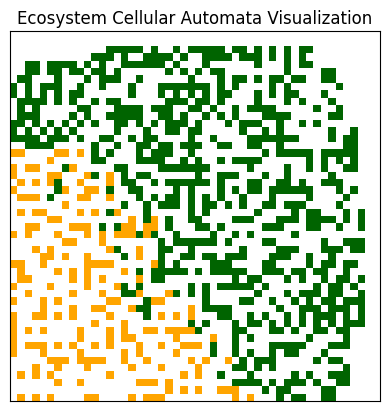

In [21]:
desert.animate(10, interval=1)

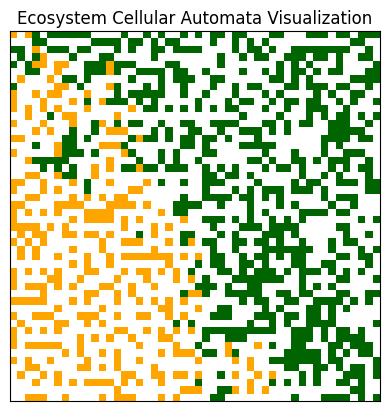

In [7]:
desert.animate(10)

## Tree vs Weed 2

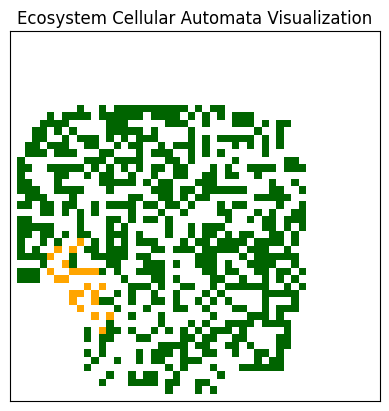

In [40]:
# Example parameters for the plant
plant_1_params = {
    "type": "Tree",
    "colour": "orange",
    "min_lifespan": 15,
    "max_lifespan": 30,
    "min_resilience": 0.85,
    "max_resilience": 1.0,
    "min_growth_rate": 0.1,
    "max_growth_rate": 0.3,
    "min_reproduction_rate": 0.1,
    "max_reproduction_rate": 0.2,
    "reproduction_area": 1}

plant_2_params = {
    "type": "Weed",
    "colour": "darkgreen",
    "min_lifespan": 2,
    "max_lifespan": 2,
    "min_resilience": 0.01,
    "max_resilience": 0.03,
    "min_growth_rate": 0.3,
    "max_growth_rate": 0.8,
    "min_reproduction_rate": 0.7,
    "max_reproduction_rate": 0.9,
    "reproduction_area": 1
}

# Create plant instances
plants = []
plants.append(Plant((15, 10), plant_1_params))
plants.append(Plant((20, 20), plant_2_params))

flora_types = [plant.type for plant in plants]
colours = ["white"] + [plant.colour for plant in plants]

params = {
    "plants": plants,
    "competition_constant": 0.5, 
    "flora_types": flora_types,
    "colours": colours
    }
# Example output to show its properties
desert = Ecosystem(50, params)

desert.animate(20, interval=1)

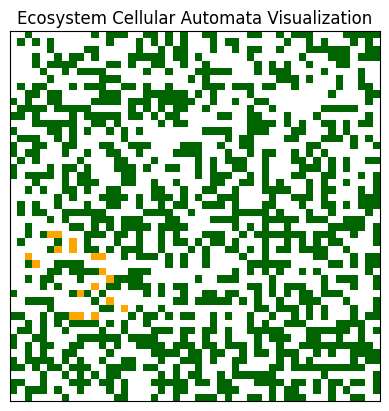

In [41]:
desert.animate(20)

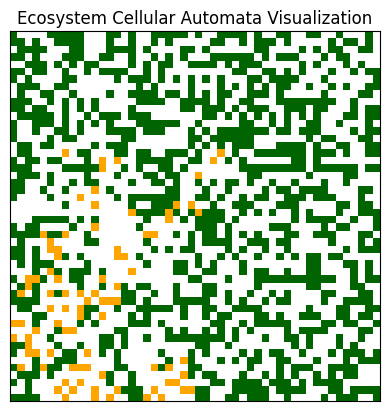

In [39]:
desert.animate(20)